[*********************100%***********************]  88 of 88 completed


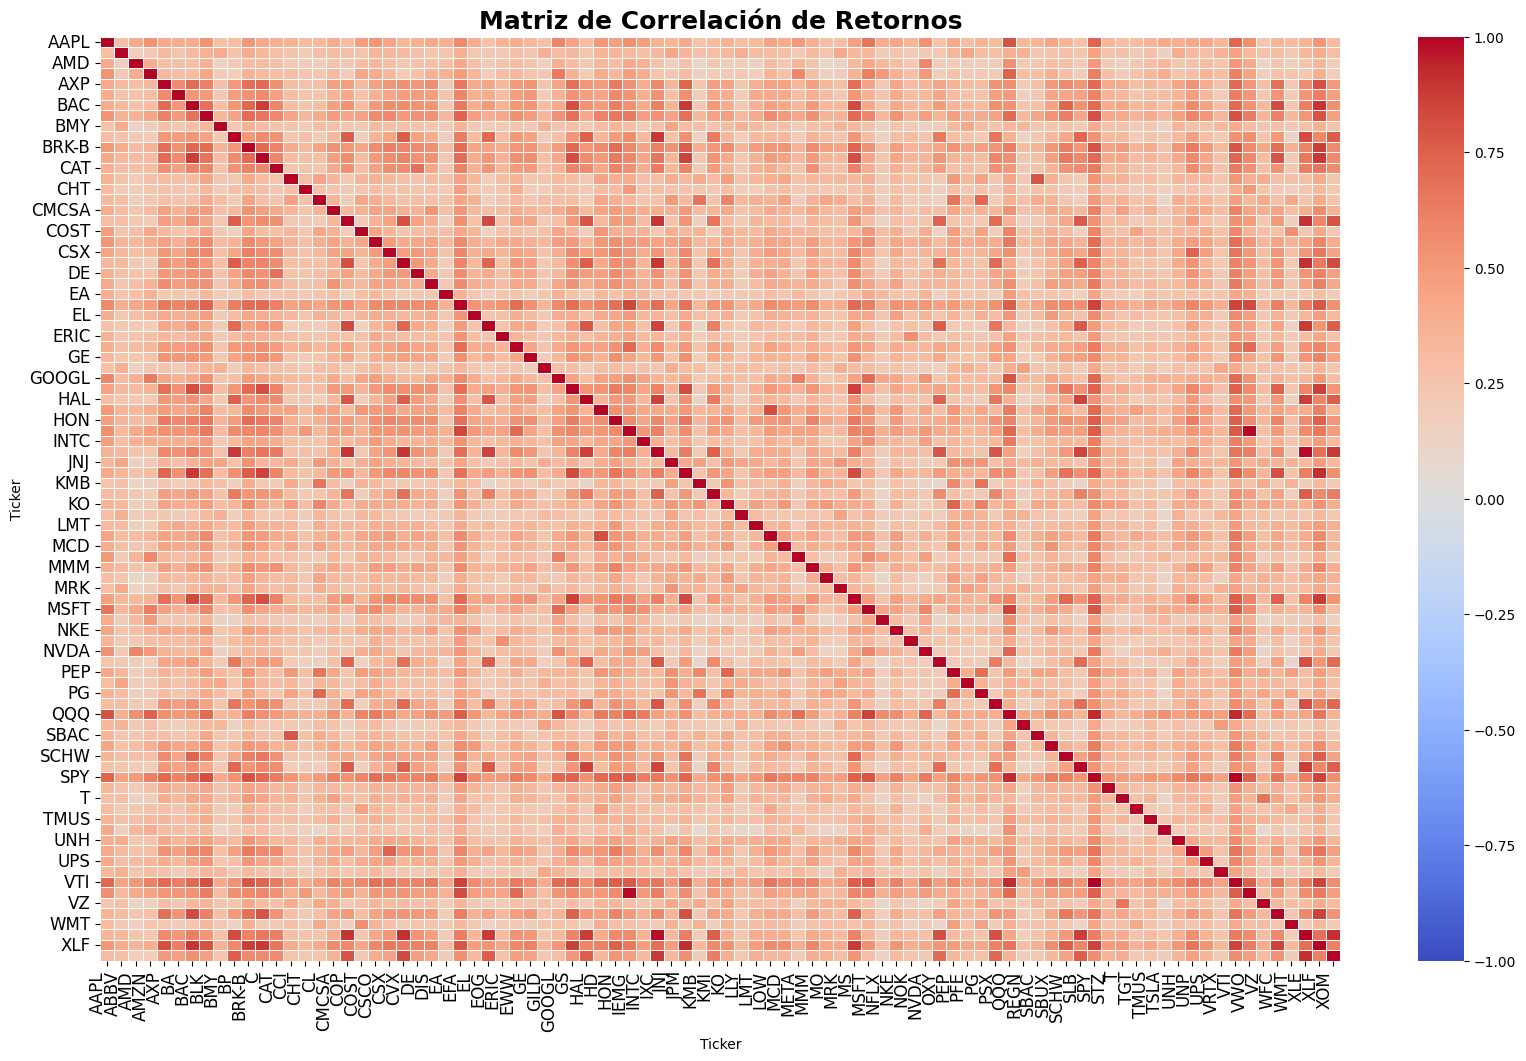

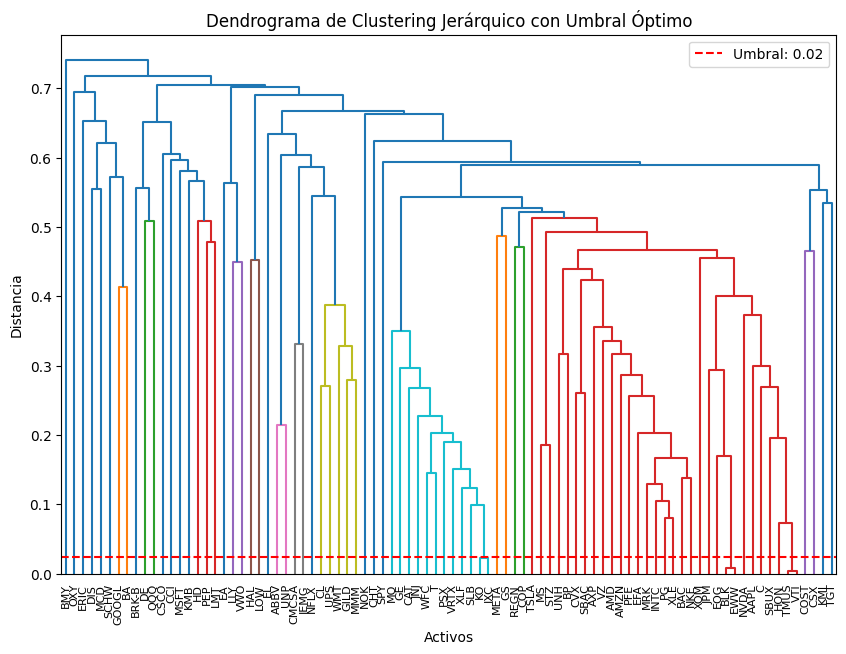

Número óptimo de clusters (Dendograma): 85
Umbral Óptimo: 0.02


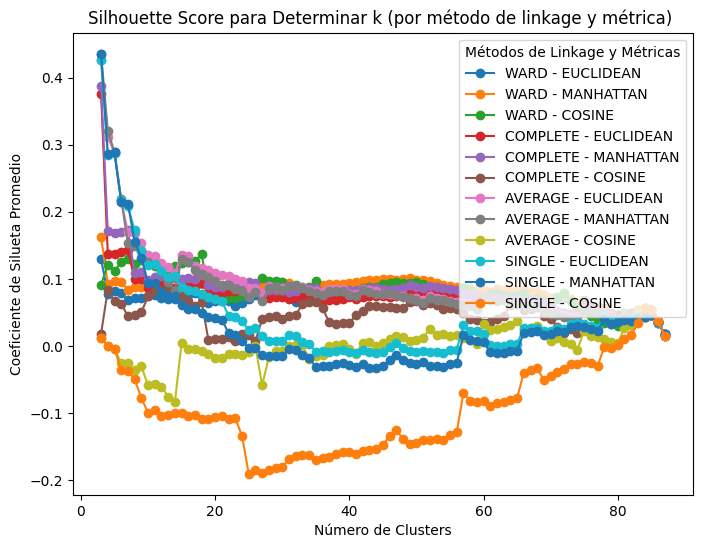

Mejor método de linkage: AVERAGE con la métrica MANHATTAN y 3 clústeres y Silhouette Score: 0.44
    k metodo_conexion    metrica     score
7   3         average  manhattan  0.435604
10  3          single  manhattan  0.435604
6   3         average  euclidean  0.425764
9   3          single  euclidean  0.425764
4   3        complete  manhattan  0.387602
3   3        complete  euclidean  0.376007
1   3            ward  manhattan  0.162015
0   3            ward  euclidean  0.129725
2   3            ward     cosine  0.091633
5   3        complete     cosine  0.018433
8   3         average     cosine  0.011834
11  3          single     cosine  0.011834


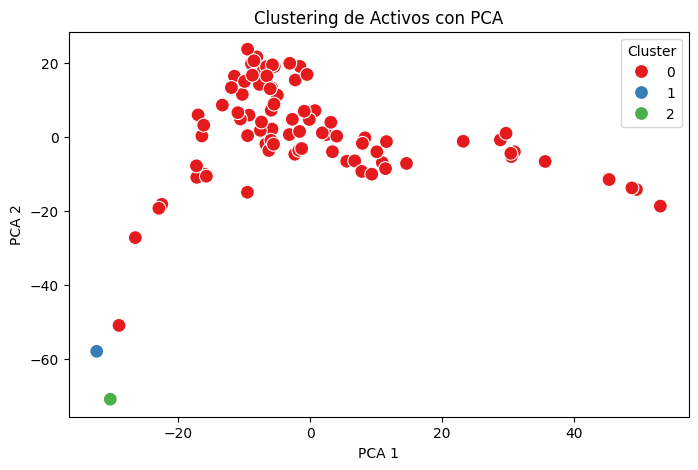

Activos Seleccionados para la Optimización de Portafolio: ['NVDA', 'ERIC', 'GOOGL']


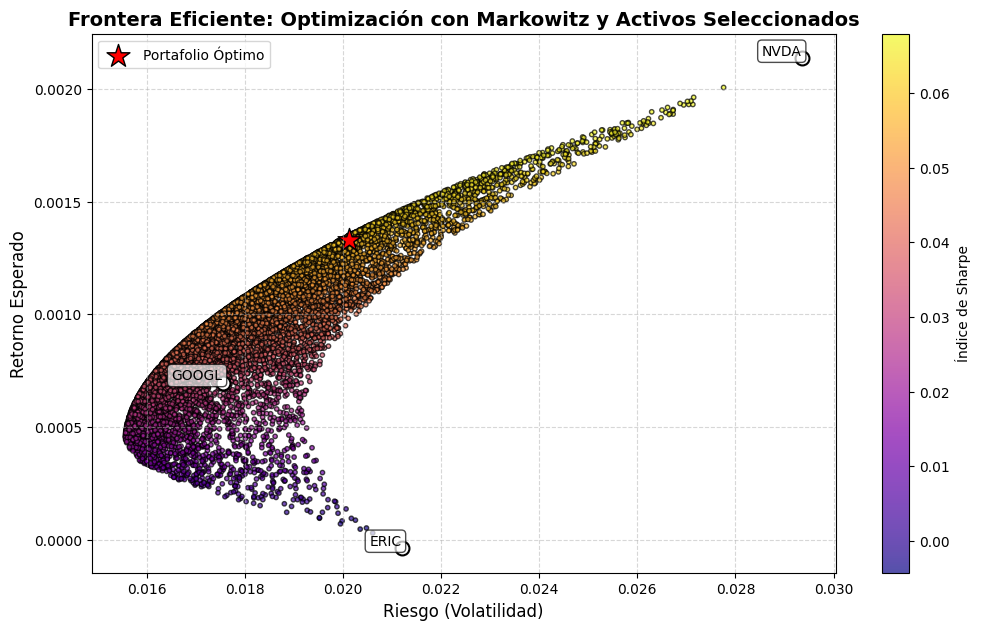

Pesos del portafolio óptimo basado en clustering jerárquico y optimización de Markowitz:
NVDA: 50.00%
ERIC: 12.00%
GOOGL: 38.00%
Retorno Esperado del Portafolio Óptimo: 0.13%
Volatilidad del Portafolio Óptimo: 2.01%
Índice Sharpe del Portafolio Óptimo: 0.0601
Caída Máxima (Drawdown Máximo) del Portafolio Óptimo: -734.80%
Ratio de Sortino del Portafolio Óptimo: 0.0871
Valor en Riesgo (VaR) al 95% de Confianza: 3.19%
Retorno Ajustado al Riesgo (RAR) del Portafolio Óptimo: 0.0660


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score
from scipy.optimize import minimize
from scipy.stats import dirichlet

TICKERS = [
    # Tecnología (Tech)
    'AAPL', 'MSFT', 'GOOGL', 'NVDA','AMZN', 'META', 'INTC', 'AMD', 'CSCO',

    # Salud (Healthcare)
    'JNJ', 'PFE', 'MRK', 'UNH', 'ABBV', 'BMY', 'GILD', 'REGN', 'VRTX', 'LLY',

    # Energía (Energy)
    'XOM', 'CVX', 'SLB', 'BP', 'COP', 'OXY', 'EOG', 'KMI', 'PSX', 'HAL',

    # Finanzas (Financials)
    'JPM', 'GS', 'BRK-B', 'C', 'BAC', 'WFC', 'MS', 'AXP', 'BLK', 'SCHW',

    # Consumo Básico (Consumer Staples)
    'KO', 'PEP', 'PG', 'WMT', 'MO', 'CL', 'KMB', 'EL', 'STZ', 'COST',

    # Consumo Discrecional (Consumer Discretionary)
    'DIS', 'TSLA', 'NFLX', 'HD', 'NKE', 'SBUX', 'MCD', 'TGT', 'LOW',

    # Industriales (Industrials)
    'BA', 'CAT', 'UPS', 'LMT', 'MMM', 'GE', 'HON', 'DE', 'UNP', 'CSX',

    # Telecomunicaciones (Telecom)
    'VZ', 'T', 'TMUS', 'CHT', 'CMCSA', 'EA', 'NOK', 'ERIC', 'CCI', 'SBAC',

    # ETFs
    'SPY', 'QQQ', 'VTI', 'EWW', 'IEMG', 'EFA', 'VWO', 'IXC', 'XLE', 'XLF',

]

datos = yf.download(TICKERS, start="2014-01-01", end="2024-12-31")['Close']

# 1. Cálculo de los retornos logarítmicos de los activos
# Calcular los retornos logarítmicos
retornos = np.log(datos / datos.shift(1)).dropna()  # Eliminar NaN resultantes del cálculo

# Matriz de correlación
matriz_correlacion = retornos.corr()

# Ajustar el tamaño de la figura según el número de activos
plt.figure(figsize=(20,12))

sns.heatmap(matriz_correlacion, annot=False, cmap='coolwarm',  # Eliminamos los valores
            vmin=-1, vmax=1,  # Limitar el rango de la barra de colores
            linewidths=0.5,  # Líneas entre celdas
            linecolor='white')  # Cambiar el color de las líneas de las celdas

# Mejorar la presentación
plt.title("Matriz de Correlación de Retornos", fontsize=18, fontweight='bold')
plt.xticks(rotation=90, ha='right', fontsize=12)  # Aumentar el tamaño de las etiquetas de las columnas
plt.yticks(rotation=0, fontsize=12)  # Aumentar el tamaño de las etiquetas de las filas

plt.show()

# 4. Normalizar los datos para Clustering Jerárquico
escalado = StandardScaler()
retornos_escalados = escalado.fit_transform(retornos.T)

# Convertir la matriz de correlación a una matriz de distancia (1 - correlación)
matriz_distancia = 1 - matriz_correlacion
# Convertir la matriz de distancia completa a una forma condensada
matriz_distancia_condensada = squareform(matriz_distancia)

def evaluar_silueta(k, metodo_conexion, metrica, datos):
    try:
        # Realizar el agrupamiento y calcular el Silhouette Score
        agrupamiento = AgglomerativeClustering(n_clusters=k, linkage=metodo_conexion)
        etiquetas = agrupamiento.fit_predict(datos)
        return silhouette_score(datos, etiquetas, metric=metrica)
    except Exception as e:
        # Manejo de errores más específico
        print(f"Error evaluando k={k} con {metodo_conexion} y métrica {metrica}: {e}")
        return -1  # Retorna un valor inválido si hay un error

# Diccionario para almacenar los resultados (en lugar de una lista)
scores_silueta = {}

# Inicializamos las variables de mejor resultado
mejor_conexion = ''
mejor_metrica = ''
mejor_score = -1
k_optimo_silueta = 0

# Evaluamos todos los métodos de linkage, métricas y valores de k
metrics = ['euclidean', 'manhattan', 'cosine']
for k in range(3, len(TICKERS)):  # Ajusta el rango de k según sea necesario
    for metodo_conexion in ['ward', 'complete', 'average', 'single']:
        for metrica in metrics:
            score = evaluar_silueta(k, metodo_conexion, metrica, retornos_escalados)
            if score != -1:  # Solo almacenamos resultados válidos
                scores_silueta[(k, metodo_conexion, metrica)] = score

                # Guardamos el mejor resultado
                if score > mejor_score:
                    mejor_score = score
                    mejor_conexion = metodo_conexion
                    mejor_metrica = metrica
                    k_optimo_silueta = k

# Generar el linkage con el mejor método de linkage
Z = linkage(matriz_distancia_condensada, method=mejor_conexion)

# Calcular el número óptimo de clusters con el Dendrograma (usando el umbral óptimo)
distancias = Z[:, 2]  # Extraemos las distancias
diferencia_distancias = np.diff(distancias)  # Diferencia entre distancias consecutivas
indice_umbral = np.argmax(diferencia_distancias)  # Mayor salto en la distancia
umbral_optimo = distancias[indice_umbral]  # Umbral óptimo

# Usamos fcluster para obtener los clusters según el umbral
clusters = fcluster(Z, umbral_optimo, criterion='distance') 

# Obtener el número óptimo de clusters
k_optimo_dendograma = len(set(clusters))

# Graficar el Dendrograma con el umbral óptimo
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=TICKERS, leaf_rotation=90, leaf_font_size=8)
separacion = umbral_optimo * 1.09
plt.axhline(y=separacion, color='r', linestyle='--', label=f'Umbral: {umbral_optimo:.2f}')
plt.title("Dendrograma de Clustering Jerárquico con Umbral Óptimo")
plt.xlabel("Activos")
plt.ylabel("Distancia")
plt.legend()
plt.show()

# Imprimir el número óptimo de clusters del Dendrograma
print(f"Número óptimo de clusters (Dendograma): {k_optimo_dendograma}")
print(f"Umbral Óptimo: {umbral_optimo:.2f}")

# Crear un DataFrame para facilitar el análisis
df_scores = pd.DataFrame([(k, metodo_conexion, metrica, score) for (k, metodo_conexion, metrica), score in scores_silueta.items()], 
                         columns=["k", "metodo_conexion", "metrica", "score"])

# Graficar el Silhouette Score promedio vs. Número de Clusters
plt.figure(figsize=(8, 6))

# Graficar el Silhouette Score para cada metodo_conexion y metrica
for metodo_conexion in ['ward', 'complete', 'average', 'single']:
    for metrica in metrics:
        scores_por_k = df_scores[(df_scores['metodo_conexion'] == metodo_conexion) & 
                                 (df_scores['metrica'] == metrica)].groupby('k')['score'].mean()
        plt.plot(scores_por_k.index, scores_por_k.values, marker='o', label=f'{metodo_conexion.upper()} - {metrica.upper()}')

plt.title("Silhouette Score para Determinar k (por método de linkage y métrica) ")
plt.xlabel("Número de Clusters")
plt.ylabel("Coeficiente de Silueta Promedio")
plt.legend(title="Métodos de Linkage y Métricas")
plt.show()

# Imprimir el mejor resultado basado en el Silhouette Score
print(f"Mejor método de linkage: {mejor_conexion.upper()} con la métrica {mejor_metrica.upper()} y {k_optimo_silueta} clústeres y Silhouette Score: {mejor_score:.2f}")
print(df_scores[df_scores['k'] == k_optimo_silueta].sort_values(by='score', ascending=False))

# 9. Aplicar Clustering Jerárquico con el número óptimo de clusters
agrupamiento_aglomerativo = AgglomerativeClustering(n_clusters=k_optimo_silueta, linkage=mejor_conexion)
etiquetas = agrupamiento_aglomerativo.fit_predict(retornos_escalados)

# 10. Visualizar Clusters con PCA
pca = PCA(n_components=2)
resultado_pca = pca.fit_transform(retornos_escalados)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=resultado_pca[:, 0], y=resultado_pca[:, 1], hue=etiquetas, palette='Set1', s=100)
plt.title("Clustering de Activos con PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.show()

# 11. Seleccionar un Activo Representante de cada Cluster basándonos en el retorno promedio
df_cluster = pd.DataFrame({'Ticker': TICKERS, 'Cluster': etiquetas})

tasa_libre_riesgo = 0.03 / 252  # Convertido a retornos diarios 

def seleccionar_activo_optimo(activos_en_cluster):
    activos_validos = set(activos_en_cluster) & set(retornos.columns)  # Intersección entre ambos conjuntos
    if not activos_validos:
        return None

    # Convertir la intersección de vuelta a una lista
    activos_validos = list(activos_validos)
    
    retornos_promedio = retornos[activos_validos].mean()
    volatilidades = retornos[activos_validos].std() + 1e-8  # Se suma un valor pequeño para evitar división por cero
    razones_sharpe = (retornos_promedio - tasa_libre_riesgo) / volatilidades
    
    return razones_sharpe.idxmax()  # Retornar el ticker con la mejor razón de Sharpe

# Seleccionamos los activos óptimos de cada cluster
activos_seleccionados = df_cluster.groupby('Cluster')['Ticker'].apply(seleccionar_activo_optimo).dropna().values

# Mostrar los activos seleccionados para optimización del portafolio
print("Activos Seleccionados para la Optimización de Portafolio:", activos_seleccionados.tolist())

# Obtener los retornos y la matriz de covarianza de los activos seleccionados
retornos_seleccionados = retornos[activos_seleccionados]
rendimientos_promedio = retornos_seleccionados.mean()  
matriz_covarianza = retornos_seleccionados.cov()    

# 3. Función de optimización para encontrar la mejor combinación de activos
def ratio_sharpe_regularizado(pesos, retornos_promedio, matriz_covarianza, lambda_ridge=0.05):
    retorno = np.sum(pesos * retornos_promedio)  # Retorno esperado del portafolio
    volatilidad = np.sqrt(np.dot(pesos.T, np.dot(matriz_covarianza, pesos)))  # Volatilidad del portafolio
    regularizacion = lambda_ridge * np.sum(pesos**2)  # Término de regularización (Ridge)
    return -((retorno - tasa_libre_riesgo) / volatilidad) + regularizacion  # Minimización del Sharpe Ratio regularizado

# 2. Optimización de la frontera eficiente
# Parámetros necesarios
num_activos = len(activos_seleccionados)
restricciones = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Restricción de que la suma de los pesos sea 1
volatilidades = np.sqrt(np.diag(matriz_covarianza))  # Volatilidad de cada activo
limites = tuple((0.01, min(0.50, 1 / vol)) for vol in volatilidades)  # Limitar pesos entre 0.01 y 0.50 o 1/volatilidad

# Pesos iniciales aleatorios
pesos_iniciales = np.random.dirichlet(np.ones(num_activos), size=1)[0]  

# Realizar la optimización
resultado_optimizacion = minimize(ratio_sharpe_regularizado, pesos_iniciales, args=(rendimientos_promedio, matriz_covarianza),
                                  method='SLSQP', bounds=limites, constraints=restricciones)
pesos_optimos = resultado_optimizacion.x  # Pesos óptimos encontrados

# 3. Cálculo del retorno y riesgo del portafolio óptimo
retorno_portafolio = np.sum(pesos_optimos * rendimientos_promedio)  # Retorno esperado del portafolio
volatilidad_portafolio = np.sqrt(np.dot(pesos_optimos.T, np.dot(matriz_covarianza, pesos_optimos)))  # Riesgo del portafolio
sharpe_optimo = (retorno_portafolio - tasa_libre_riesgo) / (volatilidad_portafolio + 1e-8)  # Índice Sharpe del portafolio óptimo

# 4. Generación de portafolios aleatorios para la frontera eficiente
num_portafolios = 10000  # Número de portafolios a generar
resultados = np.zeros((3, num_portafolios))  # Retorno, Riesgo, Sharpe Ratio
pesos_registro = np.zeros((num_portafolios, num_activos))  # Registro de pesos de cada portafolio

for idx_portafolio in range(num_portafolios):
    pesos = np.random.uniform(0.01, 0.50, num_activos)  # Pesos entre 0.01 y 0.50 para cada activo
    pesos /= np.sum(pesos)  # Normalizamos para que sumen 1 (portafolio completamente invertido)
    
    # Guardamos los pesos generados para este portafolio
    pesos_registro[idx_portafolio, :] = pesos

    # Cálculo del retorno esperado del portafolio
    retorno = np.dot(pesos, rendimientos_promedio)  # Usamos np.dot para una multiplicación eficiente (suma ponderada)

    # Cálculo de la volatilidad (riesgo) del portafolio usando la matriz de covarianza
    volatilidad = np.sqrt(np.dot(pesos.T, np.dot(matriz_covarianza, pesos)))  # Calculamos la volatilidad

    # Cálculo del índice de Sharpe para este portafolio (ajustado por tasa libre de riesgo)
    sharpe = (retorno - tasa_libre_riesgo) / volatilidad if volatilidad != 0 else 0  # Sharpe ajustado por tasa libre de riesgo
    
    # Guardamos los resultados del portafolio: retorno, volatilidad, Sharpe
    resultados[:, idx_portafolio] = [retorno, volatilidad, sharpe]

# 5. Visualización de la Frontera Eficiente
plt.figure(figsize=(12, 7))


# Graficar la frontera eficiente con colores más visibles
scatter = plt.scatter(resultados[1, :], resultados[0, :], c=resultados[2, :], cmap='plasma', alpha=0.7, edgecolors='k', s=10)
plt.colorbar(scatter, label='Índice de Sharpe')

# Resaltar el portafolio óptimo con un color llamativo
plt.scatter(volatilidad_portafolio, retorno_portafolio, color='red', edgecolors='black', marker='*', s=300, label='Portafolio Óptimo')

# Graficar los activos seleccionados con etiquetas y mejor visibilidad
volatilidades_activos = np.sqrt(np.diag(matriz_covarianza))  # Volatilidades de los activos seleccionados
for activo, vol, ret in zip(activos_seleccionados, volatilidades_activos, rendimientos_promedio):
    plt.scatter(vol, ret, color='white', edgecolors='black', marker='o', s=100, linewidth=1.5)  # Activos seleccionados
    plt.text(vol, ret, activo, fontsize=10, ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=0.3'))


# Mejorar la presentación
plt.xlabel('Riesgo (Volatilidad)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)
plt.title('Frontera Eficiente: Optimización con Markowitz y Activos Seleccionados', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

# 6. Resultados Finales
print("Pesos del portafolio óptimo basado en clustering jerárquico y optimización de Markowitz:")
for activo, peso in zip(activos_seleccionados, pesos_optimos):
    print(f"{activo}: {peso:.2%}")

print(f"Retorno Esperado del Portafolio Óptimo: {retorno_portafolio:.2%}")
print(f"Volatilidad del Portafolio Óptimo: {volatilidad_portafolio:.2%}")
print(f"Índice Sharpe del Portafolio Óptimo: {sharpe_optimo:.4f}")


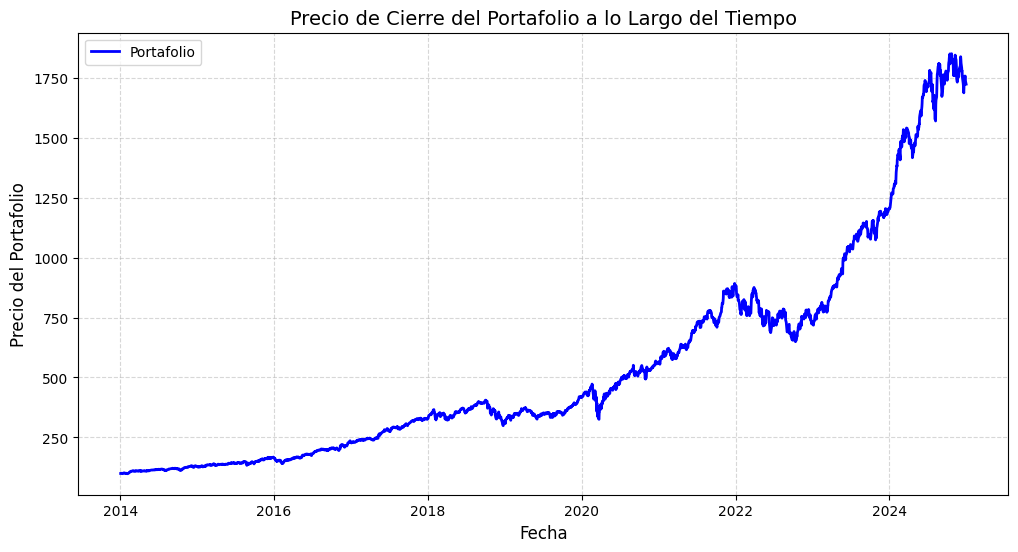

In [ ]:
# Paso 1: Calcular los rendimientos del portafolio (ya calculados anteriormente)
rendimiento_portafolio = np.dot(retornos_seleccionados, pesos_optimos)  # Rendimiento ponderado del portafolio

# Paso 2: Calcular los precios acumulados del portafolio
# Supongamos que comenzamos con un valor inicial de 100 (si lo deseas, puedes normalizar a 1)
precio_inicial_portafolio = 100  # Puedes ajustar este valor si lo deseas
precios_historicos_portafolio = (1 + rendimiento_portafolio).cumprod() * precio_inicial_portafolio  # Precio acumulado

# Paso 3: Graficar los precios históricos del portafolio
plt.figure(figsize=(12, 6))
plt.plot(retornos_seleccionados.index, precios_historicos_portafolio, label='Portafolio', color='b', linewidth=2)

# Añadir etiquetas y título
plt.title('Evolucion del Portafolio a lo Largo del Tiempo', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio del Portafolio', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar la gráfica
plt.show()